<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20251803%5D%20Thesis_erformance%20Comparison%20of%20Hybrid%20RF-LSTM%20and%20SOTA%20on%20WSN-BFSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Training on WSN-BFSF dataset (4 Classes)**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
#Imports various Python libraries necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GRU
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

In [ ]:
# Load dataset
dataset = pd.read_csv("dataset.csv")

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,Event,Time,S_Node,Node_id,Rest_Energy,Trace_Level,Mac_Type_Pckt,Source_IP_Port,Des_IP_Port,Packet_Size,TTL,Hop_Count,Broadcast_ID,Dest_Node_Num,Dest_Seq_Num,Src_Node_ID,Src_Seq_Num,Class
0,1,0.100000,79,79,600.000000,5,0,79.255,1.255,48,30,1,1,100,0,79,4,0
1,2,0.100963,78,78,599.979723,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
2,2,0.100963,76,76,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
3,2,0.100964,75,75,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
4,2,0.100964,118,118,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312101,4,656.526536,140,140,465.332078,5,800,140.255,1.255,48,30,1,31,100,16,140,68,1
312102,4,657.209643,140,140,465.191806,5,800,140.255,1.255,48,30,1,33,100,16,140,72,1
312103,4,657.891729,140,140,465.051737,5,800,140.255,1.255,48,30,1,35,100,16,140,76,1
312104,4,658.574656,140,140,464.911501,5,800,140.255,1.255,48,30,1,37,100,16,140,80,1


In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [262851  11766   7645  29844]


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler # Import StandardScaler here
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [262851 262851 262851 262851]


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

In [ ]:
# Preserve original labels for non-DL models
y_train_orig, y_test_orig = y_train.copy(), y_test.copy()

# Reshape data for DL models
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Convert labels to one-hot encoding for DL models
y_train_enc = to_categorical(y_train, num_classes=4)
y_test_enc = to_categorical(y_test, num_classes=4)

# Initialize metrics storage
metrics = []

def evaluate_model(model, X_test, y_test, model_name):
    """Helper function to evaluate models and store metrics"""
    if model_name in ['Random Forest', 'SVM']: # Changed to 'Random Forest' instead of 'RF'
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)
    else:
        y_pred = np.argmax(model.predict(X_test), axis=1)
        y_proba = model.predict(X_test)

    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'AUC-ROC': roc_auc_score(y_test_enc, y_proba, multi_class='ovr'), # y_test_enc should be used here
        'FPR': confusion_matrix(y_test, y_pred)[0,1:].sum() / confusion_matrix(y_test, y_pred)[0].sum()
    }

In [ ]:
# 1. Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train_orig)
metrics.append(evaluate_model(rf_model, X_test, y_test_orig, 'Random Forest'))

In [ ]:
# prompt: Display the value of an accuracy, precision, recall, F1-Score, AUC-ROC, and FPR of the rf_model

# Assuming you have already trained and evaluated your rf_model
# and the metrics are stored in a list called 'metrics'
for metric in metrics:
  if metric['Model'] == 'Random Forest':
    print(f"Accuracy: {metric['Accuracy']}")
    print(f"Precision: {metric['Precision']}")
    print(f"Recall: {metric['Recall']}")
    print(f"F1-Score: {metric['F1-Score']}")
    print(f"AUC-ROC: {metric['AUC-ROC']}")
    print(f"FPR: {metric['FPR']}")
    break # Exit the loop once you've found the Random Forest metrics

Accuracy: 0.99926764662523
Precision: 0.9992676479892398
Recall: 0.99926764662523
F1-Score: 0.9992675792691812
AUC-ROC: 0.9999917776025364
FPR: 0.0002472893285143618


In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    """Helper function to evaluate models and store metrics"""
    if model_name in ['Random Forest', 'SVM (Optimized)']: # Changed to 'Random Forest' instead of 'RF'
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test) # Get probability estimates for AUC-ROC
    else:
        y_pred = np.argmax(model.predict(X_test), axis=1)
        y_proba = model.predict(X_test)

    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'AUC-ROC': roc_auc_score(y_test_enc, y_proba, multi_class='ovr'), # y_test_enc should be used here
        'FPR': confusion_matrix(y_test, y_pred)[0,1:].sum() / confusion_matrix(y_test, y_pred)[0].sum()
    }

In [ ]:
# 2. Train SVM (Optimized)
from sklearn.svm import LinearSVC  # Faster than SVC for linear kernels
from sklearn.calibration import CalibratedClassifierCV  # For probability estimates

# Optimized SVM configuration
svm_model = LinearSVC(
    dual=False,  # Faster when n_samples > n_features
    tol=0.01,    # Increased tolerance for faster convergence
    C=0.1,       # Smaller regularization parameter
    max_iter=500,# Limit iterations (prevents long runs)
    random_state=42
)

# Train on subset of data (stratified sample)
_, X_train_sub, _, y_train_sub = train_test_split(
    X_train, y_train_orig,
    train_size=0.3,  # Use 30% of training data
    stratify=y_train_orig,
    random_state=42
)

# Train model
svm_model.fit(X_train_sub, y_train_sub)

# Calibrate for probability estimates
calibrated_svm = CalibratedClassifierCV(svm_model, method='sigmoid')
calibrated_svm.fit(X_train_sub, y_train_sub)

metrics.append(evaluate_model(calibrated_svm, X_test, y_test_orig, 'SVM (Optimized)'))

In [ ]:
# prompt: Display the value of an accuracy, precision, recall, F1-Score, AUC-ROC, and FPR of the SVM (Optimized)

# Assuming you have already trained and evaluated your svm_model
# and the metrics are stored in a list called 'metrics'
for metric in metrics:
  if metric['Model'] == 'SVM (Optimized)':
    print(f"Accuracy: {metric['Accuracy']}")
    print(f"Precision: {metric['Precision']}")
    print(f"Recall: {metric['Recall']}")
    print(f"F1-Score: {metric['F1-Score']}")
    print(f"AUC-ROC: {metric['AUC-ROC']}")
    print(f"FPR: {metric['FPR']}")
    break # Exit the loop once you've found the SVM (Optimized) metrics

Accuracy: 0.796890827036204
Precision: 0.7950356561251779
Recall: 0.796890827036204
F1-Score: 0.7889695251273364
AUC-ROC: 0.9291669970147554
FPR: 0.4404793608521971


In [ ]:
# 3. Train Standalone LSTM
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    Dense(4, activation='softmax')])

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_reshaped, y_train_enc, epochs=30, batch_size=64, validation_split=0.2, verbose=0)
metrics.append(evaluate_model(lstm_model, X_test_reshaped, y_test_orig, 'LSTM'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6572/6572 ━━━━━━━━━━━━━━━━━━━━ 5s 818us/step
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 5s 784us/step


In [ ]:
# prompt: Display the value of an accuracy, precision, recall, F1-Score, AUC-ROC, and FPR of the LSTM

# Assuming you have already trained and evaluated your lstm_model
# and the metrics are stored in a list called 'metrics'
for metric in metrics:
  if metric['Model'] == 'LSTM':
    print(f"Accuracy: {metric['Accuracy']}")
    print(f"Precision: {metric['Precision']}")
    print(f"Recall: {metric['Recall']}")
    print(f"F1-Score: {metric['F1-Score']}")
    print(f"AUC-ROC: {metric['AUC-ROC']}")
    print(f"FPR: {metric['FPR']}")
    break # Exit the loop once you've found the LSTM metrics

Accuracy: 0.9388437376653145
Precision: 0.9420804906409167
Recall: 0.9388437376653145
F1-Score: 0.9384200585827104
AUC-ROC: 0.9913725975873144
FPR: 0.15628685562107666


In [ ]:
# 4. Train CNN
cnn_model = Sequential([
    Conv1D(64, kernel_size=1, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')])

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train_reshaped, y_train_enc, epochs=30, batch_size=64, validation_split=0.2, verbose=0)
metrics.append(evaluate_model(cnn_model, X_test_reshaped, y_test_orig, 'CNN'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6572/6572 ━━━━━━━━━━━━━━━━━━━━ 4s 601us/step
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 4s 600us/step


In [ ]:
# prompt: Display the value of an accuracy, precision, recall, F1-Score, AUC-ROC, and FPR of the CNN

# Assuming you have already trained and evaluated your cnn_model
# and the metrics are stored in a list called 'metrics'
for metric in metrics:
  if metric['Model'] == 'CNN':
    print(f"Accuracy: {metric['Accuracy']}")
    print(f"Precision: {metric['Precision']}")
    print(f"Recall: {metric['Recall']}")
    print(f"F1-Score: {metric['F1-Score']}")
    print(f"AUC-ROC: {metric['AUC-ROC']}")
    print(f"FPR: {metric['FPR']}")
    break # Exit the loop once you've found the CNN metrics

Accuracy: 0.9799934373528755
Precision: 0.9800701354226709
Recall: 0.9799934373528755
F1-Score: 0.979991468200224
AUC-ROC: 0.9987800931419254
FPR: 0.029046984972417728


In [ ]:
# 5. Train GRU
gru_model = Sequential([
    GRU(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    Dense(4, activation='softmax')])
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.fit(X_train_reshaped, y_train_enc, epochs=30, batch_size=64, validation_split=0.2, verbose=0)
metrics.append(evaluate_model(gru_model, X_test_reshaped, y_test_orig, 'GRU'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6572/6572 ━━━━━━━━━━━━━━━━━━━━ 6s 840us/step
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 6s 847us/step


In [ ]:
# prompt: Display the value of an accuracy, precision, recall, F1-Score, AUC-ROC, and FPR of the GRU

# Assuming you have already trained and evaluated your gru_model
# and the metrics are stored in a list called 'metrics'
for metric in metrics:
  if metric['Model'] == 'GRU':
    print(f"Accuracy: {metric['Accuracy']}")
    print(f"Precision: {metric['Precision']}")
    print(f"Recall: {metric['Recall']}")
    print(f"F1-Score: {metric['F1-Score']}")
    print(f"AUC-ROC: {metric['AUC-ROC']}")
    print(f"FPR: {metric['FPR']}")
    break # Exit the loop once you've found the GRU metrics

Accuracy: 0.9436420789324761
Precision: 0.9468227560700211
Recall: 0.9436420789324761
F1-Score: 0.9433549657989736
AUC-ROC: 0.9928577157022092
FPR: 0.1455963477268404


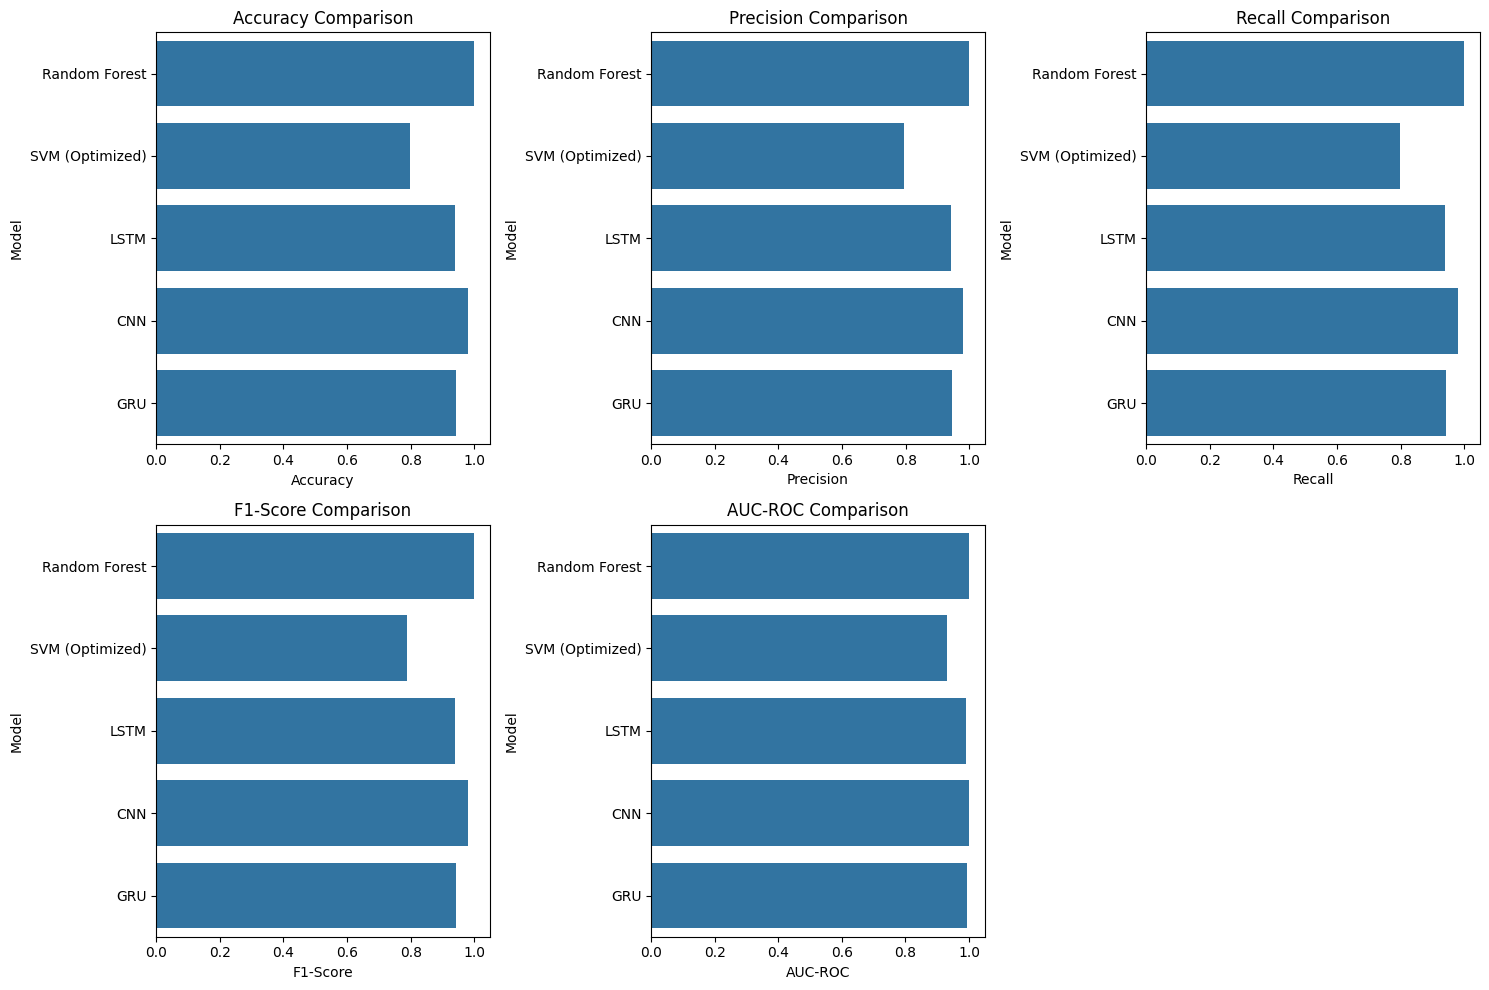


Performance Comparison:
                 Accuracy  Precision  Recall  F1-Score  AUC-ROC     FPR
Model                                                                  
Random Forest      0.9993     0.9993  0.9993    0.9993   1.0000  0.0002
SVM (Optimized)    0.7969     0.7950  0.7969    0.7890   0.9292  0.4405
LSTM               0.9388     0.9421  0.9388    0.9384   0.9914  0.1563
CNN                0.9800     0.9801  0.9800    0.9800   0.9988  0.0290
GRU                0.9436     0.9468  0.9436    0.9434   0.9929  0.1456


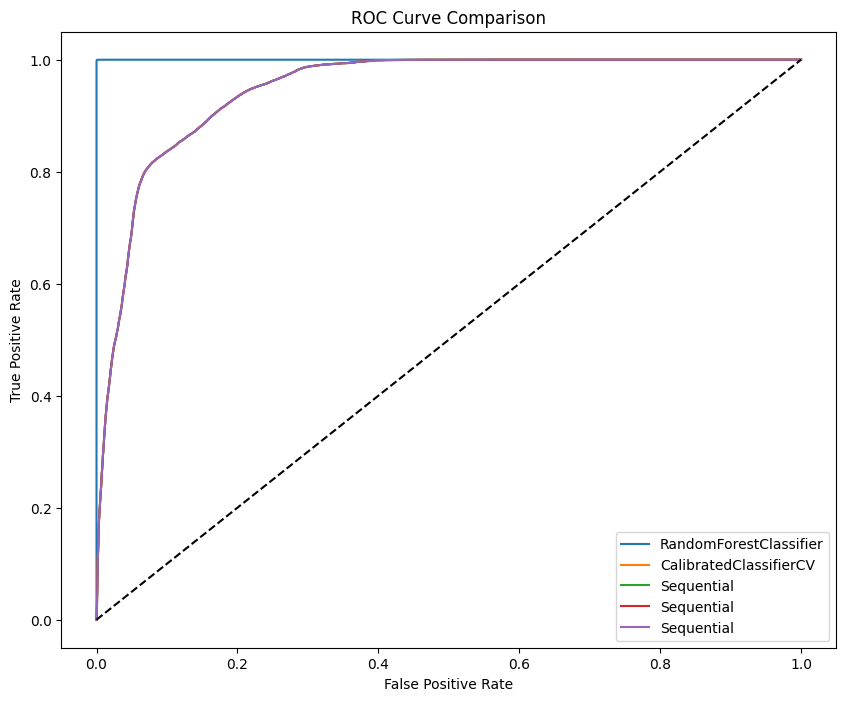

In [ ]:
# Create comparison DataFrame
results_df = pd.DataFrame(metrics).set_index('Model')

# Visualization
plt.figure(figsize=(15, 10))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=results_df[metric], y=results_df.index)
    plt.title(f'{metric} Comparison')
    plt.xlabel(metric)
plt.tight_layout()
plt.show()

# Print metrics table
print("\nPerformance Comparison:")
print(results_df.round(4))

# Import roc_curve
from sklearn.metrics import roc_curve # Import roc_curve here

# ROC Curve Comparison
plt.figure(figsize=(10, 8))
for model in [rf_model, calibrated_svm, lstm_model, cnn_model, gru_model]: # Use calibrated_svm instead of svm_model
    if hasattr(model, 'predict_proba'):
        if isinstance(model, (Sequential)): # Check if the model is a Keras model
            y_proba = model.predict(X_test_reshaped)  # Use X_test_reshaped for DL models
        else:
            y_proba = model.predict_proba(X_test)  # Use X_test for models with predict_proba
    # The elif condition is no longer needed as calibrated_svm has predict_proba
    #else:
        #y_proba = model.predict(X_test_reshaped)  # Use X_test_reshaped for DL models


    fpr, tpr, _ = roc_curve(y_test_enc.ravel(), y_proba.ravel())
    plt.plot(fpr, tpr, label=type(model).__name__)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()